<a href="https://colab.research.google.com/github/Onyinye31/A-GNN-APPROACH-TO-DETECTING-AUTOMOBILE-INSURANCE-FRAUD/blob/main/Oversampling_GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%capture
!git clone https://github.com/joerg84/Graph_Powered_ML_Workshop.git
!rsync -av Graph_Powered_ML_Workshop/ ./ --exclude=.git
!pip3 install dgl
!pip3 install numpy
!pip3 install torch
!pip3 install networkx
!pip3 install matplotlib

In [ ]:
import os, sys
from copy import deepcopy
import numpy as np
import pandas as pd

import torch as th
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
print(f"Torch version: {th.__version__}.  CUDA version: {th.version.cuda}")

Torch version: 1.13.0+cu116.  CUDA version: 11.6


In [ ]:
dgl_version = f"dgl-cu{th.version.cuda.replace('.', '')}==0.9.1"
dgl_version

'dgl-cu116==0.9.1'

In [ ]:
# Follow instructions at https://www.dgl.ai/pages/start.html
!{sys.executable} -m pip install {dgl_version} -f https://data.dgl.ai/wheels/repo.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.dgl.ai/wheels/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.3/246.3 MB 4.1 MB/s eta 0:00:00


In [ ]:
os.environ['DGLBACKEND'] = 'pytorch'
import dgl
from dgl import function as fn

In [ ]:
dgl.__version__

'0.9.1'

In [ ]:
import dgl.dataloading

In [ ]:
from dgl.dataloading import NodeDataLoader

In [ ]:
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
device

device(type='cuda')

LOAD DATASET

In [ ]:
#load dataset
Dataset = pd.read_csv("/content/carclaims.csv")


In [ ]:
#Finding Duplicate 
Dataset.duplicated(subset = None, keep = 'first')

0        False
1        False
2        False
3        False
4        False
         ...  
15415    False
15416    False
15417    False
15418    False
15419    False
Length: 15420, dtype: bool

In [ ]:
# drop all rows that have NaN/None values
Dataset2=Dataset.dropna()
print(Dataset2)

      Month  WeekOfMonth  DayOfWeek     Make AccidentArea DayOfWeekClaimed  \
0       Dec            5  Wednesday    Honda        Urban          Tuesday   
1       Jan            3  Wednesday    Honda        Urban           Monday   
2       Oct            5     Friday    Honda        Urban         Thursday   
3       Jun            2   Saturday   Toyota        Rural           Friday   
4       Jan            5     Monday    Honda        Urban          Tuesday   
...     ...          ...        ...      ...          ...              ...   
15415   Nov            4     Friday   Toyota        Urban          Tuesday   
15416   Nov            5   Thursday  Pontiac        Urban           Friday   
15417   Nov            5   Thursday   Toyota        Rural           Friday   
15418   Dec            1     Monday   Toyota        Urban         Thursday   
15419   Dec            2  Wednesday   Toyota        Urban         Thursday   

      MonthClaimed  WeekOfMonthClaimed     Sex MaritalStatus  .

In [ ]:
# Replace the Labels to 0 and 1
Dataset2.loc[Dataset2['FraudFound'] == 'No','FraudFound'] = 0
Dataset2.loc[Dataset2['FraudFound'] == 'Yes','FraudFound'] = 1

Dataset2['FraudFound'] = Dataset2['FraudFound'].astype(int)

In [ ]:
#selected based on discretion 
df_new= Dataset2[['PolicyNumber','AccidentArea','Sex',\
       'MaritalStatus','Fault','DriverRating','RepNumber',\
       'PoliceReportFiled', 'WitnessPresent',\
       'BasePolicy', 'FraudFound']]

In [ ]:
from sklearn.utils import resample

**Oversampling** 

In [ ]:
n = df_new.FraudFound.value_counts()[0]

df_majority = df_new[df_new.FraudFound==0]
df_minority = df_new[df_new.FraudFound==1]

df_minority_upsampled = resample(df_minority,replace=True,n_samples = n,random_state=42)

df_upsampled = pd.concat([df_majority,df_minority_upsampled])
df_upsampled.FraudFound.value_counts()

0    14497
1    14497
Name: FraudFound, dtype: int64

In [ ]:
import matplotlib.pyplot as plt

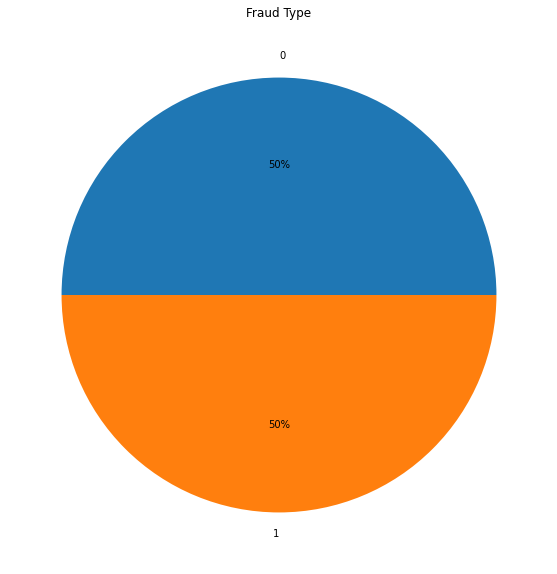

In [ ]:
#Fraud Type Percentage
plt.figure(figsize=(20,10))
plt.pie(df_upsampled.FraudFound.value_counts().values,labels=df_upsampled.FraudFound.value_counts().index,  autopct='%.0f%%')
plt.title("Fraud Type")
plt.show()

**Converting Dataset to Graph Data**

In [ ]:
max(df_upsampled["PolicyNumber"].value_counts())

30

NODE

In [ ]:
# Sort to define the order of nodes
sorted_df = df_upsampled.sort_values(by="PolicyNumber")
# Select node features
node_features = sorted_df[['AccidentArea','Sex',\
       'MaritalStatus','Fault','RepNumber','BasePolicy',\
       'PoliceReportFiled', 'WitnessPresent']]

In [ ]:
# Convert non-numeric columns
pd.set_option('mode.chained_assignment', None)
#positions = node_features.str.split(",", expand=True)
#node_features["first_position"] = positions[0]

In [ ]:
X_ohe = pd.get_dummies(node_features.astype(str), drop_first=True)


In [ ]:
X_ohe.head()

,AccidentArea_Urban,Sex_Male,MaritalStatus_Married,MaritalStatus_Single,MaritalStatus_Widow,Fault_Third Party,RepNumber_10,RepNumber_11,RepNumber_12,RepNumber_13,...,RepNumber_4,RepNumber_5,RepNumber_6,RepNumber_7,RepNumber_8,RepNumber_9,BasePolicy_Collision,BasePolicy_Liability,PoliceReportFiled_Yes,WitnessPresent_Yes
0,1,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
1,1,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
2,1,1,1,0,0,0,0,0,0,0,...,0,0,0,1,0,0,1,0,0,0
3,0,1,1,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,1,0
4,1,0,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [ ]:
# Convert to numpy
x = X_ohe.to_numpy()
x.shape

(28994, 25)

In [ ]:
from sklearn import preprocessing

X= preprocessing.normalize(x)

In [ ]:
X

array([[0.5       , 0.        , 0.        , ..., 0.5       , 0.        ,
        0.        ],
       [0.40824829, 0.40824829, 0.        , ..., 0.        , 0.40824829,
        0.        ],
       [0.4472136 , 0.4472136 , 0.4472136 , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.4472136 , 0.4472136 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.4472136 , 0.4472136 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.4472136 , 0.4472136 , 0.        , ..., 0.        , 0.        ,
        0.        ]])

LABELS

In [ ]:
#labels
sorted_df = df_upsampled.sort_values(by="PolicyNumber")
# Select labels
labels = sorted_df["FraudFound"]
labels.head()

0    0
1    0
2    0
3    0
4    0
Name: FraudFound, dtype: int64

In [ ]:
# Convert to numpy
y = labels.to_numpy()
y.shape

(28994,)

In [ ]:
y

array([0, 0, 0, ..., 1, 1, 1])

EDGES

In [ ]:
# Remap 
df_upsampled["PolicyNumber"] = df_upsampled.reset_index().index

In [ ]:
df_upsampled["DriverRating"].value_counts()

3    7505
1    7306
4    7219
2    6964
Name: DriverRating, dtype: int64

In [ ]:
import itertools
import numpy as np

types = df_upsampled["DriverRating"].unique()
all_edges = np.array([], dtype=np.int32).reshape((0, 2))
for base in types:
    types_df = df_upsampled[df_upsampled["DriverRating"] == base]
    individuals = types_df["PolicyNumber"].values
    # Build all combinations
    permutations = list(itertools.combinations(individuals, 2))
    edges_source = [e[0] for e in permutations]
    edges_target = [e[1] for e in permutations]
    types_edges = np.column_stack([edges_source, edges_target])
    all_edges = np.vstack([all_edges, types_edges])
# Convert to Pytorch Geometric format
edge_index = all_edges.transpose()
edge_index # [2, num_edges]

array([[    0,     0,     0, ..., 28989, 28989, 28990],
       [    4,     6,     9, ..., 28990, 28992, 28992]])

In [ ]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

1.13.0+cu116
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 72.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 23.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 8.9 MB/s eta 0:00:00


In [ ]:
X=X.astype(np.float32)

In [ ]:
X

array([[0.5      , 0.       , 0.       , ..., 0.5      , 0.       ,
        0.       ],
       [0.4082483, 0.4082483, 0.       , ..., 0.       , 0.4082483,
        0.       ],
       [0.4472136, 0.4472136, 0.4472136, ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.4472136, 0.4472136, 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.4472136, 0.4472136, 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.4472136, 0.4472136, 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

In [ ]:
from torch_geometric.data import Data

In [ ]:
data = Data(x=torch.tensor(X), edge_index=torch.tensor(edge_index), y=torch.tensor(y) , num_classes = 2 ) 

In [ ]:
data

Data(x=[28994, 25], edge_index=[2, 105142462], y=[28994], num_classes=2)

In [ ]:
data.x

tensor([[0.5000, 0.0000, 0.0000,  ..., 0.5000, 0.0000, 0.0000],
        [0.4082, 0.4082, 0.0000,  ..., 0.0000, 0.4082, 0.0000],
        [0.4472, 0.4472, 0.4472,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.4472, 0.4472, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.4472, 0.4472, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.4472, 0.4472, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [ ]:
data.edge_index

tensor([[    0,     0,     0,  ..., 28989, 28989, 28990],
        [    4,     6,     9,  ..., 28990, 28992, 28992]])

In [ ]:
data.y

tensor([0, 0, 0,  ..., 1, 1, 1])

Split to training and testing 

In [ ]:
train_ratio = 0.2
num_nodes = data.x.shape[0]
num_train = int(num_nodes * train_ratio)
idx = [i for i in range(num_nodes)]

In [ ]:
np.random.shuffle(idx)
train_mask = torch.full_like(data.y, False, dtype=bool)
train_mask[idx[:num_train]] = True
test_mask = torch.full_like(data.y, False, dtype=bool)
test_mask[idx[num_train:]] = True

In [ ]:
print(train_mask)
# tensor([ True, False, False, False, False])
print(test_mask)
# tensor([False,  True,  True,  True,  True])

tensor([False, False, False,  ..., False, False, False])
tensor([True, True, True,  ..., True, True, True])


In [ ]:

# check number of edges of the graph
print(data.num_edges)

105142462


In [ ]:

# check number of nodes of the graph
print(data.num_nodes)
     

28994


In [ ]:

# check number of features of the graph
print(data.num_features)

25


In [ ]:

# check if graph is directed
print(data.is_directed())

True


In [ ]:
data.edge_index

tensor([[    0,     0,     0,  ..., 28989, 28989, 28990],
        [    4,     6,     9,  ..., 28990, 28992, 28992]])

In [ ]:
data.x

tensor([[0.5000, 0.0000, 0.0000,  ..., 0.5000, 0.0000, 0.0000],
        [0.4082, 0.4082, 0.0000,  ..., 0.0000, 0.4082, 0.0000],
        [0.4472, 0.4472, 0.4472,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.4472, 0.4472, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.4472, 0.4472, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.4472, 0.4472, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])

In [ ]:
# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')

Number of nodes: 28994
Number of edges: 105142462
Average node degree: 3626.35


In [ ]:
print(f'Number of graphs: {len(data)}')
print(f'Number of features: {data.num_features}')
print(f'Number of classes: {data.num_classes}')

Number of graphs: 4
Number of features: 25
Number of classes: 2


**GNN MODEL**

In [ ]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(data.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, data.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(25, 16)
  (conv2): GCNConv(16, 2)
)


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


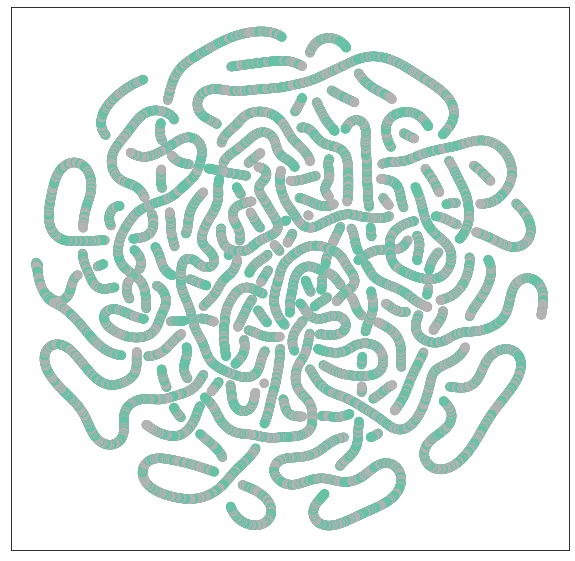

In [ ]:
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[train_mask], data.y[train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      output = pred[test_mask]
      return output
    

for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

In [ ]:
output = test()

In [ ]:
from sklearn.metrics import confusion_matrix , classification_report

In [ ]:
print(classification_report(data.y[test_mask],output))

              precision    recall  f1-score   support

           0       0.50      0.94      0.65      6531
           1       0.52      0.07      0.12      6609

    accuracy                           0.50     13140
   macro avg       0.51      0.50      0.39     13140
weighted avg       0.51      0.50      0.38     13140



In [ ]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.6828
